In [ ]:
# import libraries

import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter


In [ ]:
# import data
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_PATH = os.path.join(ROOT_DIR, "data", "Vectorized_BU_Hub_Courses.csv")

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# optional filtering
excluded_colleges = ['CGS', 'SAR', 'QST']
excluded_departments = ['BI', 'PY']
excluded_course_codes = ['CAS WR 153E']
excluded_keywords = ['Summer', 'Analysis']

df = df[
    ~df['Course Code'].str.extract(r'([A-Z]+)', expand=False).isin(excluded_colleges) &
    ~df['Course Code'].str.extract(r'[A-Z]+\s+([A-Z]+)', expand=False).isin(excluded_departments) &
    ~df['Course Code'].isin(excluded_course_codes) &
    ~df['Course Title'].str.contains('|'.join(excluded_keywords), case=False, na=False)
].reset_index(drop=True)


In [ ]:
# # Entire HUB requirement
# requirement_counts = {
#     'Philosophical Inquiry and Life’s Meanings': 1,
#     'Aesthetic Exploration': 1,
#     'Historical Consciousness': 1,
#     'Social Inquiry I': 1,
#     'Social Inquiry II': 1,
#     'Scientific Inquiry I': 1,
#     'Scientific Inquiry II': 1,
#     'Quantitative Reasoning I': 1,
#     'Quantitative Reasoning II': 1,
#     'First-Year Writing Seminar': 1,
#     'Writing-Intensive Course': 2,
#     'Writing, Research, and Inquiry': 1,
#     'Oral and/or Signed Communication': 1,
#     'Digital/Multimedia Expression': 1,
#     'Critical Thinking': 2,
#     'Research and Information Literacy': 2,
#     'Teamwork / Collaboration': 2,
#     'Creativity / Innovation': 2,
#     'The Individual in Community': 1,
#     'Global Citizenship and Intercultural Literacy': 2,
#     'Ethical Reasoning': 1
# }

# specific HUB requirements
requirement_counts = {
    'Philosophical Inquiry and Life’s Meanings': 1,
    'Aesthetic Exploration': 1,
    'Historical Consciousness': 1,
    'Social Inquiry I': 0,
    'Social Inquiry II': 0,
    'Scientific Inquiry I': 0,
    'Scientific Inquiry II': 0,
    'Quantitative Reasoning I': 0,
    'Quantitative Reasoning II': 0,
    'First-Year Writing Seminar': 0,
    'Writing-Intensive Course': 1,
    'Writing, Research, and Inquiry': 0,
    'Oral and/or Signed Communication': 0,
    'Digital/Multimedia Expression': 0,
    'Critical Thinking': 0,
    'Research and Information Literacy': 0,
    'Teamwork / Collaboration': 1,
    'Creativity / Innovation': 0,
    'The Individual in Community': 1,
    'Global Citizenship and Intercultural Literacy': 1,
    'Ethical Reasoning': 1
}

# bipartite graph construction
B = nx.Graph()
courses = df["Course Code"] + " - " + df["Course Title"]
hub_cols = [col for col in df.columns if col in requirement_counts]

for idx, course in enumerate(courses):
    for req in hub_cols:
        if df.loc[idx, req] == 1 and requirement_counts[req] > 0:
            B.add_edge(course, req)

# define bipartite sets
course_nodes = list(courses)
requirement_nodes = [r for r in hub_cols if requirement_counts[r] > 0]


In [14]:
# expand requirement nodes with multiplicity
expanded_reqs = []
for r, count in requirement_counts.items():
    if count > 0:
        expanded_reqs.extend([f"{r}__{i}" for i in range(count)])

# map back for visualization
req_base_map = {f"{r}__{i}": r for r in requirement_counts for i in range(requirement_counts[r]) if requirement_counts[r] > 0}

# extended bipartite graph
G = nx.Graph()
G.add_nodes_from(courses, bipartite=0)
G.add_nodes_from(expanded_reqs, bipartite=1)

# reconnect with multiplicity
for idx, course in enumerate(courses):
    for req in hub_cols:
        if df.loc[idx, req] == 1 and requirement_counts[req] > 0:
            for i in range(requirement_counts[req]):
                G.add_edge(course, f"{req}__{i}")

# greedy cover algorithm
remaining_reqs = set(expanded_reqs)
selected_courses = set()

while remaining_reqs:
    best_course = max(courses, key=lambda c: len(set(G[c]) & remaining_reqs))
    selected_courses.add(best_course)
    remaining_reqs -= set(G[best_course])

print(f"Selected {len(selected_courses)} courses:")
for c in selected_courses:
    print("-", c)


Selected 4 courses:
- CAS AA 113 - Introduction to Antiracism
- CAS AN 344 - Culture and Social Change in Japan (area)
- CAS CC 201 - Core Humanities 3: Renaissance, Rediscovery, and Reformation
- CAS RN 214 - Islam


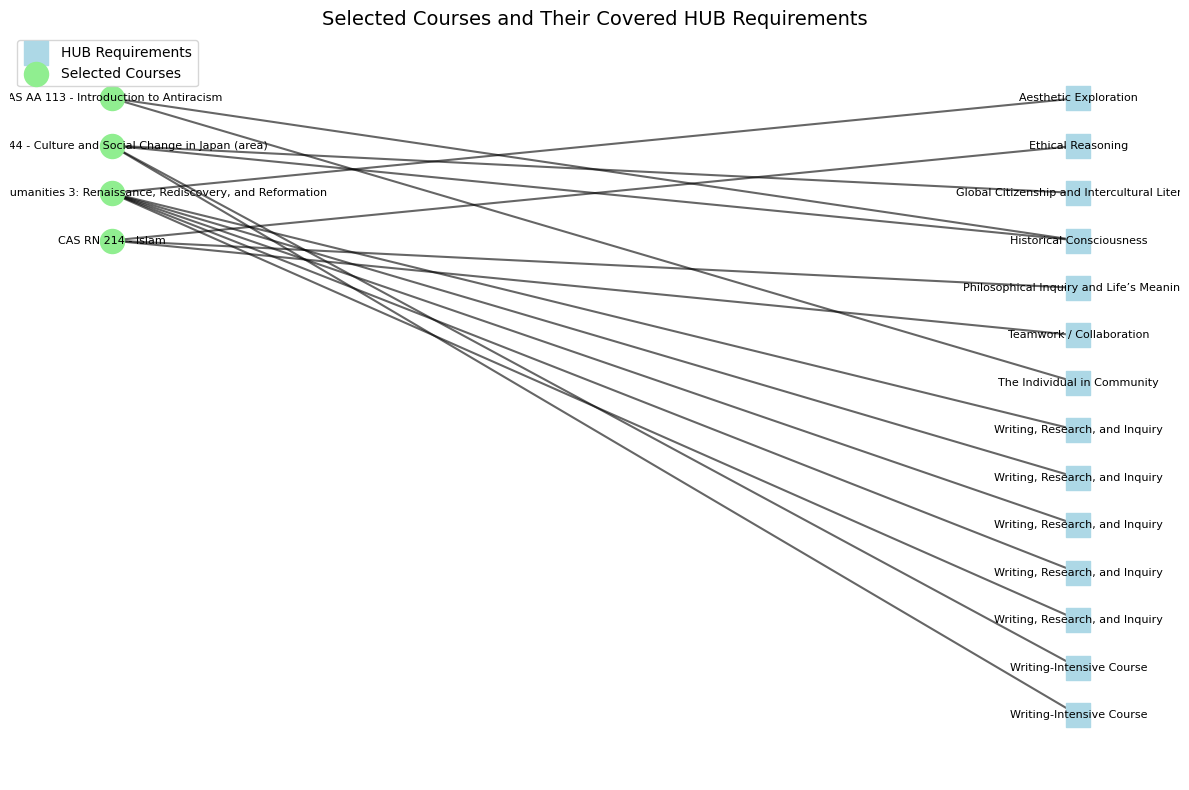

In [15]:
# visualization

def draw_selected_solution(G, selected_courses, req_base_map):
    # Get all HUB nodes connected to selected courses
    covered_reqs = set()
    for course in selected_courses:
        covered_reqs.update(G[course])

    # Subgraph: only selected courses and their HUBs
    H = G.subgraph(selected_courses.union(covered_reqs)).copy()

    # Layout: left (courses), right (HUBs)
    pos = {}
    left_x, right_x = 0, 1
    spacing_y = 1.5

    sorted_courses = sorted(selected_courses)
    sorted_reqs = sorted(covered_reqs)

    for i, c in enumerate(sorted_courses):
        pos[c] = (left_x, -i * spacing_y)

    for j, r in enumerate(sorted_reqs):
        pos[r] = (right_x, -j * spacing_y)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title("Selected Courses and Their Covered HUB Requirements", fontsize=14)

    # Edges
    nx.draw_networkx_edges(H, pos, edgelist=H.edges(), width=1.5, alpha=0.6)

    # Nodes: HUBs (blue squares), Courses (green circles)
    nx.draw_networkx_nodes(H, pos,
                           nodelist=sorted_reqs,
                           node_color='lightblue',
                           node_shape='s',
                           label="HUB Requirements")

    nx.draw_networkx_nodes(H, pos,
                           nodelist=sorted_courses,
                           node_color='lightgreen',
                           node_shape='o',
                           label="Selected Courses")

    # Labels
    labels = {node: req_base_map.get(node, node) for node in H.nodes()}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

    plt.axis('off')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Run visualization
draw_selected_solution(G, selected_courses, req_base_map)
